## Let's start by installing some dependencies. 




In [ ]:
!pip3 install box2d-py stable-baselines3 pyglet stable-baselines3 pyvirtualdisplay torchviz --quiet
!pip3 install --upgrade gym[Box_2D] --quiet
!apt-get install x11-utils -qq
!apt-get install -y xvfb python-opengl -qq

     |████████████████████████████████| 448 kB 6.5 MB/s 
     |████████████████████████████████| 176 kB 46.7 MB/s 


# Welcome to ML From Scratch: Advanced RL, Day 2!

This Colab will take you through a few exercises aimed at helping you complete your own implementation of Advantaged Actor Critic (A2C), which was first introduced on Day 1. Here's an outline for what you'll do today:
1. First, you'll be taken through a few light exercises to get you familiar with `torch`. `torch` is a very common ML library in Python, and so it's good to have a light working knowledge of some of its more common features. Importantly, what you learn in these exercises is a minimal subset of `torch` that will help you complete the following exercises. It should serve as a good springboard to get you comfortable with it so that you can use it in future projects as well.
2. Next, you'll get familiar with `gym` and `stable-baselines`. `gym` is a package provided by OpenAI, which offers a simple API for creating environments for training RL agents. OpenAI offers a few pre-built environments out of the box, as well. `stable-baselines` is a package of stable RL algorithms. `stable-baselines` is compatible with `gym` out of the box. `stable-baselines` is a useful tool when doing RL research - sometimes we just want to see if existing algorithms can perform some task, and we don't want to have to code any old algorithm from scratch. RL algorithms (as you'll find today) are rather hard to debug. For our purposes, understand the training dynamics of a reference solution will be useful when it comes to debugging. 
3. Finally, you'll code A2C from (relative) scratch. A good portion of the setup has been done for you, so you can focus on deeply understanding and implementing the core of the algorithm itself. We'll start with an A2C that just uses a single actor. For those who finish that today, there are some challenge exercises. 

### With further ado, go ahead and run this first set of import statements, and let's get started!

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import base64
import os
import torch
import io
import datetime
from torch import nn
from collections import namedtuple, OrderedDict

# Part 1: `torch` basics - How to build a neural network

`torch` is a module that allows you to easily build and train artificial neural networks. The basic units of computation are objects called `Tensor`s. A `Tensor` object is a lot like a `numpy.ndarray`, except that it holds some extra information. This extra information is a list of operations that were done on the `Tensor` (or what the `Tensor` participated in), so that you can perform automatic differentiation on the `Tensor`.

Over the following short exercises, we'll build some intuition for what's going on with the `torch` networks that we'll wind up using to implement A2C.

### Exercise: Make two `torch.tensor`s and compute some gradients

Let $\vec{x} = (1, 1)^\top$ and $\vec{y} = (1, 1)^\top$. First, a tiny bit of paper and pencil math. Calculate
$$ \frac{\partial}{\partial \vec{x}} \sum_{i = 1}^N \frac{1}{N} (\vec{x}_i - \vec{y}_i^2) $$ 
and 
$$ \frac{\partial}{\partial \vec{y}} \sum_{i = 1}^N \frac{1}{N} (\vec{x}_i - \vec{y}_i^2) $$ 
where, in this case, $N = 2$. (Do the calculation symbolically, and then evaluate with the given values of $\vec{x}$, $\vec{y}$.)

Now, set the values of `x_grad` and `y_grad` to be what you calculated for $\frac{\partial}{\partial \vec{x}}$ and $ \frac{\partial}{\partial \vec{y}}$, respectively (make sure they are of type `torch.tensor`!).

Finally, perform the same gradients above using two tensors. You may find the documentation in https://pytorch.org/docs/stable/tensors.html to be helpful.

If you did everything correctly, you should see "Correct!" printed out below. 

In [ ]:
x = # your code here!
y = # your code here!
# compute the above gradients here


x_grad = # your code here!
y_grad = # your code here!
if torch.equal(x_grad, x.grad) and torch.equal(y_grad, y.grad):
  print('Correct!')
else:
  print('Seems like something is wrong :(')

### If you did the above right...

You might be wondering a bit what's going on under the hood. We can use a little handy tool called `torchviz` to see what's going on a bit better. Note that it's tucked into the little `pip install` things above, and so you can easily install it on your machine if you find that you want to use it.

`torch` is a handy tool because it allows us to perform automatic differentiation on tensors. Since we often optimize neural networks using some form of gradient descent, and since calulcating gradients by hand is borderline torturous, having a computational tool that can handle differentiation over multiple layers of a network is quite useful.

Of course, how it performs those kinds of differentiations is often taken for granted. The underlying principle is quite neat, though. For each operation between two tensors, `torch` generates a new tensor, the output of the operation, that stores information of how it was generated in a **call graph**. When it comes time to differentiate the output with respect to some variable that produced it, `torch` will go **backward** (hence why you might've called `backward()` above) through the call graph, computing gradients as it steps through.

Now that sounds all fine and dandy, but I think a visualization kind of helps. Run the cell below:

In [ ]:
from torchviz import make_dot

x = torch.tensor([1.0, -1.0], requires_grad=True)
y = torch.tensor([1.0, 1.0], requires_grad=True)
loss = (x - y.pow(2)).mean()
make_dot(loss, params={'x' : x, 'y' : y, 'loss' : loss})

### So what's going on here...

For the moment, let's ignore the `AccumulateGrad` blocks (though they are important, just not right now). The graph above shows you how `torch` is thinking about your operations. `y`, for example, before any operations happen including `x`, goes through:
```
y -> AccumulateGrad -> PowBackward0
```
since we're ignoring the `AccumulateGrad` for now, it's fairly easy to see that this computational graph shows that `y` is first squared. Then, it joins with `x`, and we see that the operation that joins them together (the operation that both branches above join on) is `SubBackward0` (or subtraction). Then the result goes through a `MeanBackward0` block, and we get the (named) variable, `loss`. 

You can inspect how these graphs are built by looking at the `.grad_fn` and `.grad_fn.next_functions` fields of `loss`:



In [ ]:
print('loss.grad_fn:', loss.grad_fn)
print('loss.grad_fn.next_functions:', loss.grad_fn.next_functions)

Now you might have noticed that all of these operation blocks have `Backward` in them. This is not particularly meaningful, except that it hints at why these graphs are useful. The notion of **backpropagation** comes from propagating gradients backwards through layers of a neural network, since this is effectively how you calculate a gradient with respect to the network paramters, by way of the chain rule from calculus (you might know of this as the "backward pass" through a network). You would be right to think that this kind of computational graph sort of resembles some schematics of neural networks that you might see in a textbook. We can think of our series of operations sort of like a network, in the sense that in order to take a gradient, we start with the outermost operation (or layer), and work our way inward (backward through the network, a la chain rule). 

Note that when we were calculating the gradient above, we were basically doing that, just by hand. In order for `pytorch` to perform the differentiation, which is initated when you call `backward()` on some `tensor`, the routine traverses the above schematized call graph, starting at the terminal node, and performing gradient operations based on the type of `{Op}Backward` block that it sees, iteratively going backward in the graph, applying the chain rule, until it reachs a leaf node. In the above call graph:

```
>>> loss.is_leaf
>>> False

>>> x.is_leaf
>>> True

>>> y.is_leaf
>>> True
```
Or else, `x` and `y` are leaf nodes, and the results of operations on leaf (or non-leaf) nodes are, by induction, not leaf nodes themselves. Hitting a leaf node prompts the `backward()` routine to stop, and it stores the result of the gradient with respect to that leaf node that it has at that point in the leaf's `.grad` field.

`pytorch` will only include something in a call graph if it thinks you might want to differentiate some function with respect to that node (you can guess why it would be useless to store information about a variable that you'll never differentiate in a large call graph that you might have with a hundred-parameter neural network). Watch what happens when we set `requires_grad=False` on `y`:

In [ ]:
x = torch.tensor([1.0, -1.0], requires_grad=True)
y = torch.tensor([1.0, 1.0], requires_grad=False)
loss = (x - y.pow(2)).mean()
make_dot(loss, params={'x' : x, 'y' : y, 'loss' : loss})

### `y` disappears...

And that's a good thing. `pytorch` shouldn't store stuff it won't need - we're already going to be asking a lot of our computers when we start using large networks with many parameters. We should try to save on memory any way we can, as long as the consequences aren't deleterious.

Another way to do this is to use a function called `detach()`. You can call `detach()` on any `tensor`, and effectively what it does is it detaches that tensor from the call chain, returning the detached tensor (with `requires_grad=False`). As demonstration:

In [ ]:
x = torch.tensor([1.0, -1.0], requires_grad=True)
y = torch.tensor([1.0, 1.0], requires_grad=True)
x = x.detach()  # x is now detached from the call chain, which means it no longer requires a gradient
loss = (x - y.pow(2)).mean()
make_dot(loss, params={'x' : x, 'y' : y, 'loss' : loss})

In [ ]:
x = torch.tensor([1.0, -1.0], requires_grad=True)
y = torch.tensor([1.0, 1.0], requires_grad=True)
loss = (x - y.pow(2)).mean()
loss = loss.detach() # loss is now detached from the call chain, so our schematic is different
make_dot(loss, params={'x' : x, 'y' : y, 'loss' : loss})

In [ ]:
# but...
make_dot((x - y.pow(2)).mean(), params={'x' : x, 'y' : y})

## Okay, let's build a neural network.

`torch` provides a suite of neural network tools, all within the `torch.nn` module. We'll go over a few important parts of the `nn` module, though this is by no means comprehensive. Again, for your leisure, the `nn` documentation (a surprisingly pleasant read!): https://pytorch.org/docs/stable/nn.html

### `torch.nn.Module`

The `Module` class is a basic network base class. When you want to build your own class that is like a network (in that you can use `torch` autograd functions, automatically handle CPU/GPU allocation, etc.), you'll usually have your class inherit the `nn.Module` class. You'll see most classes that inherit `nn.Module` do something like this:

```python
class MyNetwork(nn.Module):
  def __init__(self):
    super(MyNetwork, self).__init__()  # init superclass
    self.params = params_generator_function()
  
  def forward(self, X):
    return self.params(X)
```

You'll see that we override the `nn.Module`'s definition of `forward()`. This is a requirement when deriving a class from `nn.Module`. `forward()` defines what happens when we pass an input through the network. 

For reasons that are relatively arcane and not worth going into, you have to define `forward()`, but you should never call it. The short reason for this is that, once you define `forward()`, `nn.Module` will use it within a more complicated function it defines behind the scenes that does a bunch of important stuff to make sure the `forward()` call goes through okay. If the above is confusing to you, don't dwell on it too much. Just note that if you want to pass some input, `X`, into a network `net`, and you want to get the output stored as `y`:
- **correct**: `y = net(X)`
- **incorrect**: `y = net.forward(X)`

`Module` exposes some interesting functions (for example, `cpu()` sends parameters to the CPU, and `cuda()` sends parameters to a specified CUDA device). These are not essential for our purposes, but they are interesting if you want to read about them in the documentation.

### `torch.nn.Sequential`
`Sequential` is a chain of modules. The `Sequential` class is effectively a straightforward way of building networks that have multiple layers, without having to hand-implement each forward pass. In other words, the following networks are equivalent:

```python
class NetworkA(nn.Module):
  def __init__(self):
    super(NetworkA, self).__init__()
    self.layer_1 = nn.Linear(64, 32)
    self.nl_1 = nn.ReLU()
    self.layer_2 = nn.Linear(32, 1)
    self.last = nn.Softmax()
  
  def forward(self, X):
    y = self.layer_1(X)
    y = self.nl_1(y)
    y = self.layer_2(y)
    return self.last(y)

NetworkB = nn.Sequential(
  nn.Linear(64, 32),
  nn.ReLU(),
  nn.Linear(32, 1),
  nn.Softmax()
)
```
see for yourself:

In [ ]:
# define these once since they are randomly initialized
layer_1 = nn.Linear(64, 32)
nl_1 = nn.ReLU()
layer_2 = nn.Linear(32, 1)
nl_2 = nn.Tanh()

class NetworkA(nn.Module):
  def __init__(self):
    super(NetworkA, self).__init__()
    self.layer_1 = layer_1
    self.nl_1 = nl_1
    self.layer_2 = layer_2
    self.last = nl_2
  
  def forward(self, X):
    y = self.layer_1(X)
    y = self.nl_1(y)
    y = self.layer_2(y)
    return self.last(y)

NetworkB = nn.Sequential(
  layer_1,
  nl_1,
  layer_2,
  nl_2
)

X = torch.randn(64)
NetA = NetworkA()
assert(torch.equal(NetA(X), NetworkB(X)))

### Note that above...

We used `nn.Linear` and `nn.ReLU`. `torch` provides a ton of ready made network layer types, and their `forward()` routines are all implemented, so it's quite easy to actually implement a neural network using `torch`. Take a look in the documentation for a list of available layer types and non-linearities.

#### Exercise: Make a neural network with a specified architecture
Make a class `MyClass` that has the following structure:
- input layer of size (64, 32) [first number is input size, second is output size]
- a ReLU non-linearity layer 
- a linear layer of size (32, 32)
- a tanh non-linearity layer
- a linear layer of size (32, 16)
- a ReLU non-linearity layer
- a linear layer of size (16, 4)

If you've done it correctly, you should be able to run the cell below it with the asserts, and you'll see no errors.

In [ ]:
# your code here

In [ ]:
net = MyClass()
assert isinstance(list(net.modules())[-1], nn.Linear)
assert isinstance(list(net.modules())[-2], nn.ReLU)
assert isinstance(list(net.modules())[-7], nn.Linear)

## Putting it all together
So we understand gradients in `torch` and how to build neural networks. Let's work through an example of getting a network to output something (marginally) interesting. Suppose we have some input $\vec{x} \in \mathbb{R}^N$, if we let $g(\cdot)$ be our network, we want to train our network so that $g(\vec{x}) = f(\vec{x}) \ \ \forall x \in \mathbb{R}^N$ where $f(\vec{x}) = \vec{1}^\top \vec{x}$, or else, the elementwise sum of $\vec{x}$. Of course, it's profoundly silly to use a neural network to try and learn this function in practice, but it's a useful exercise to get acquainted with the tools around for optimizing neural networks.

Now, in theory, we have what we need to perform gradient descent on our networks. That being said, implementing that by hand (even with autograd) is annoying, and part of working with neural networks is knowing when someone else has implemented something already. For our purposes, we'll be using a premade optimizer, which will take in our model parameters, and optimize them directly according to the results of the autograd functions we've delved into above. 

### `nn.optim`
`torch` provides the optimizer package `optim`, which contains classes and methods that implement various standard optimization algorithms. You can take a look at the full documentation here: https://pytorch.org/docs/stable/optim.html

Often, you'll see an optimizer used like this:
```python
model = Model() # this should be of type nn.Module
optimizer = nn.optim.Adam(model.parameters(), lr=1e-3)
example_inp, example_out = training_data[0]
model_output = model(example_inp)
loss = loss_fn(model_output, example_out)
loss.backward()
optimizer.step()
```
In the above block, we:
1. create our model and optimizer, instantiating the optimizer directly with the parameters of the model
2. get a training input and output, get the model output when passing through the training input
3. perform some loss calculation, then call `.backward()` on this loss, which will propagate gradients up through parameters of the model that contributed to the computation of this loss
4. step the optimizer, which performs an optimization step on the model parameters according to their `.grad` field, using the learning rate supplied

#### Exercise, optimize $g$ to be $f$
In the cell below, generate a neural network that can map inputs of dimension 64 to output size 1, and then generate some train and test data (all data should consist of an input and output; the input can be a vector of the appropriate size where each element is drawn from some random distribution, and the output can just be that sum of that vector). Use a squared error loss function, and use a `torch.optim` optimizer to train the weights of your network correctly. For this case, make learning online (ie, you should adjust the weights after calculating the loss on each example). Make a figure that shows the loss over time - you should see it go to zero. If everything is done correctly (and as simply as possible), you should be able to inspect the network parameters, and they should all be 1's (except for the bias, which should be zero). 

NB: Since this just a linear regression problem, try to keep it fun by using a  small learning rate, ie. something upper bounded by $10^{-3}$.

Hint: Browse through the documentation linked above for some inspiration. If you're getting some noisy loss, try and train for more trials and adjust your learning rate. Make everything easy on yourself and do not include any non-linearities in your network - you shouldn't need them for this problem.

In [ ]:
# your code here!

### And finally, what is gradient accumulation?

Online learning is good in some instances, but for problems like this one which aren't very dynamic, or in cases where we want to use multiple samples generated by a single set of network paramters to update said parameters, we will want to exploit a `torch` functionality called **gradient accumulation**. Gradient accumulation is conceptually quite simple: it just refers to the situation in which backwards passes are performed from multiple training samples, without any individual backward pass changing the parameters of the network. Instead, parameters are updated according to the *accumulated* gradients over all the backwards passes (this is where those `AccumulateGrad` boxes above come into play). Note that because `.backward()` passes the gradient calculations up the call graph (where they are stored) without actually changing anything, it's very easy to modify an online learning algorithm to one that uses batched gradient accumulation.

#### Exercise: accumulate some gradients

Do the same exercise as above, but now with gradient accumulation (ie, don't update your parameters after every example). Try and use a batch size of 100. You should be able to use a much larger learning rate, and you should observe quite fast convergence.

In [ ]:
# your code here!

## So that's (a brief brush over) `torch`

There is *way* more to `torch` than covered here, but hopefully this gives you an informative, if small, taste of how you should use `torch` in your own research. You shouldn't need more than what's covered above to have a good idea of what's going on in the rest of the exercises, though if you feel lost, `torch` documentation is quite good. 

---

# Part 2: Implementing Advantaged Actor Critic (A2C)

Now that you have a sense of how `torch` works, let's get going on A2C. On Monday, you got a taste of how A2C works. Here's a schematic demonstrating the basic principles behind it:

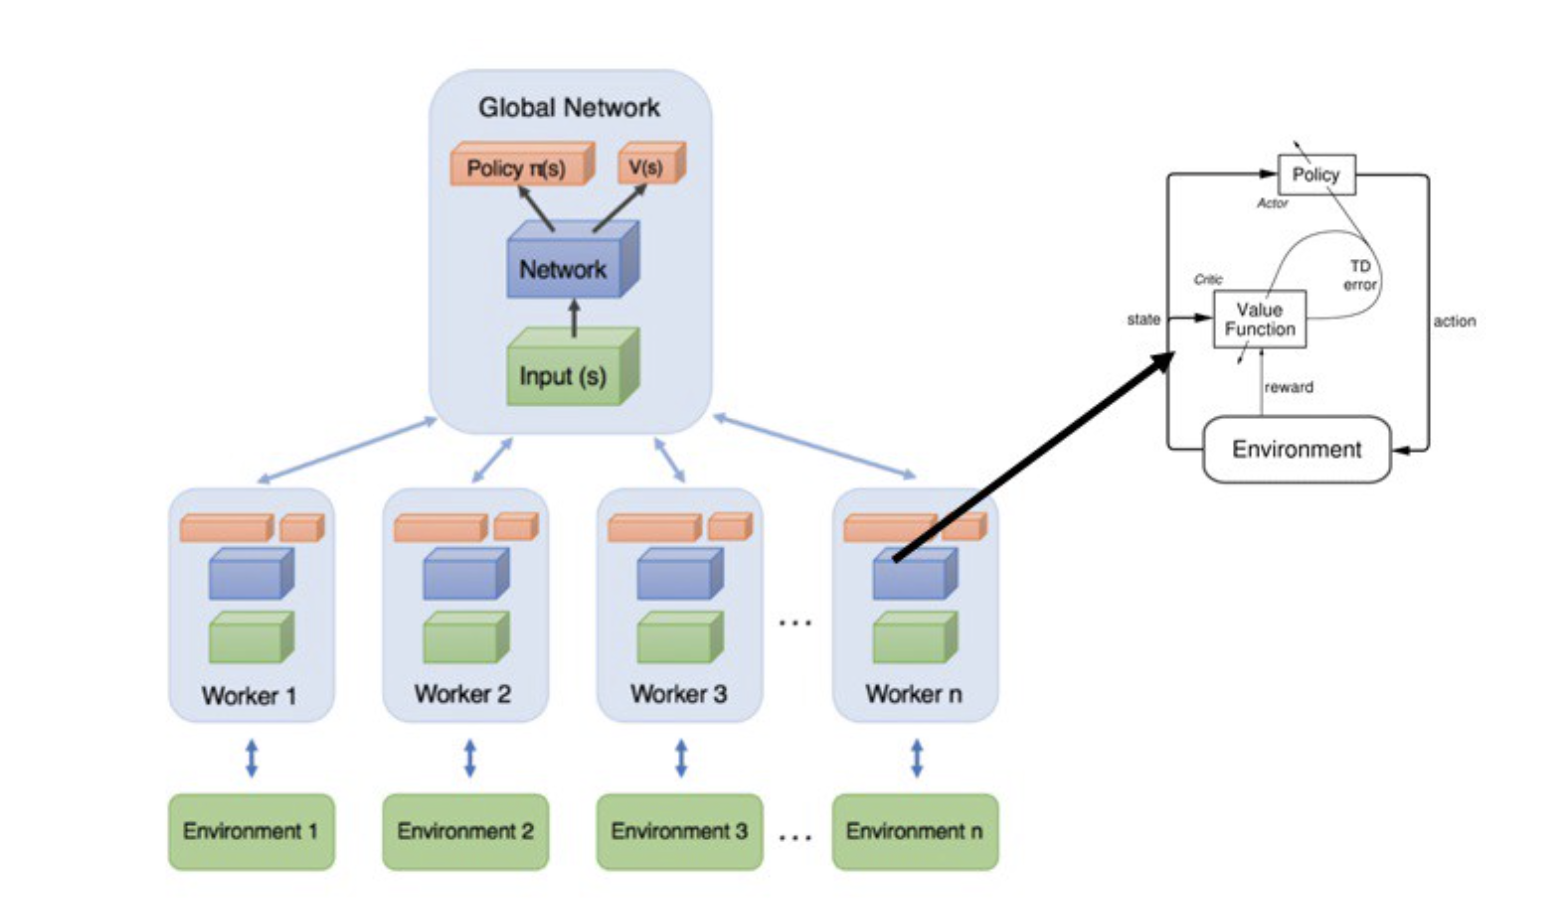

You'll notice that it seems like the child actors/critics are asynchronously interacting with the global actor/critic. This is because, in this schematic, they are! A2C descends from a very similar algorithm called A3C, which stands for Asynchronous Advantaged Actor Critic. The idea of this algorithm was that the workers would update global weights asynchronously, which the authors theorized would function sort of like memory replay in their DQN model. (Here's the original A3C paper for your leisure: https://arxiv.org/pdf/1602.01783.pdf). It turns out that the asynchrony, in addition to being a pain to implement, was actually only impairing performance, and that sequential weight updates from multiple workers worked just fine for training the kinds of models used in the paper.

Advantaged Actor Critic is quite concpetually simple - it's basically just a normal actor-critic algorithm, except that we update our policy weights in the direction of their gradient of the log-policy times the advantage ($Q(s,a) - V(s)$), rather than just $Q(s,a)$.

## Part 2A: Getting acquainted with `gym` and `stable_baselines3`

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

## The following cell has some helpful utils

`SaveOnBestTrainingRewardCallback` derives `BaseCallback`, which is a `stable-baselines` util class that helps you keep track of your model while it trains (source: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/monitor_training.ipynb#scrollTo=BIedd7Pz9sOs). `SaveOnBestTrainingRewardCallback` will periodically check on your model and save the parameters associated with models that achieve the greatest reward on a given run (in short, it keeps track of the best model as it trains). `plot_results` is a function you can call to visualize how your model improves over the course of training. 

**NB**: These functions are useful for tracking the reference implementation (provided by `stable-baselines`), for which we don't have the ability to build in tracking. These will be less useful when we implement A2C from scratch

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True
  
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

## Let's see what the state of the art can do

`stable-baselines` provides a stable implementation of A2C, which we'll use here to demonstrate what a plausible solution to the continuous lunar landing problem can look like. `stable-baselines` interacts quite seamlessly with `gym`. Executing the following code cell trains an A2C instance on the `LunarLanderContinuous-v2` env (we'll dive a bit deeper into the lunar lander task below when we implement it). 

In [ ]:
log_dir = "/tmp/gym/stable_baselines/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make('LunarLanderContinuous-v2')
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, verbose=0)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=200000, callback=callback)

plot_results(log_dir)

In [ ]:
def visualize_policy(model, log_dir, use_sb_api=True):
  """
  :param model - the trained model
  :param log_dir - where you logged your training data
  :use_sb_api - use stable-baslines api when pushing the network forward. Set this to False when you visualize your own model
  """
  env = DummyVecEnv([lambda: gym.make('LunarLanderContinuous-v2')])

  # Record the video starting at the first step
  video_folder = '{}video/'.format(log_dir)
  video_prefix = '{}'.format(str(datetime.datetime.now()))
  video_prefix = video_prefix.replace(' ', '').replace('-', '_').replace('.', 'p').replace(':', '_')
  os.makedirs(video_folder, exist_ok=True)
  video_length = 5000
  env = VecVideoRecorder(env, 
                        video_folder,
                        record_video_trigger=lambda x: x == 0, 
                        video_length=video_length,
                        name_prefix=video_prefix)
  obs = env.reset()
  for i in range(video_length):
      if use_sb_api:
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
      else:
        action_dist, value = model(obs)
        action = action_dist['mean']
        obs, reward, done, info = env.step(action.detach().data.numpy())
      
      if done:
        break

  env.close()
  video_files = os.listdir(video_folder)
  video_file = None
  for f in video_files:
    if f.startswith(video_prefix) and f.endswith('mp4'):
      video_file = f
  video = io.open(os.path.join(video_folder, video_file), 'r+b').read() 
  encoded = base64.b64encode(video)
  ipythondisplay.display(ipythondisplay.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))


In [ ]:
visualize_policy(model, log_dir)

## Part 2B: The real fun begins

Let's try and implement our own version of A2C. We'll start with a very (relatively) simple setup: We're only going to be using one actor interacting with a single environment. There's some pre-filled code blocks for setting things up, but feel free to modify parameters (like network size, number of layers), as long as you keep the number of outputs for each network fixed.

We'll define a wrapper class: `ActorCritic`. `ActorCritic` is what we'll use to instantiate our actor and critic. Think of it as a thin layer around a `torch` network. It makes altering the structure of each network relatively simple. 

**Important: if you change the `layer_type` or `nonlinearity` argument when instantiating a new `ModuleWrapper`, make sure *not* to create an instance of the layer_type/nonlinearty (ie:**
- **correct:** `actor = ActorCritic(x, y, z, nonlinearity=nn.ReLU)`
- **incorrect:** `actor = ActorCritic(x, y, z, nonlinearity=nn.ReLU())`)

Inspect the `forward()` method to understand what the network is outputting. Understanding this is crucial to completing the implementation.

For your convenience, here is the pseudocode for the algorithm:
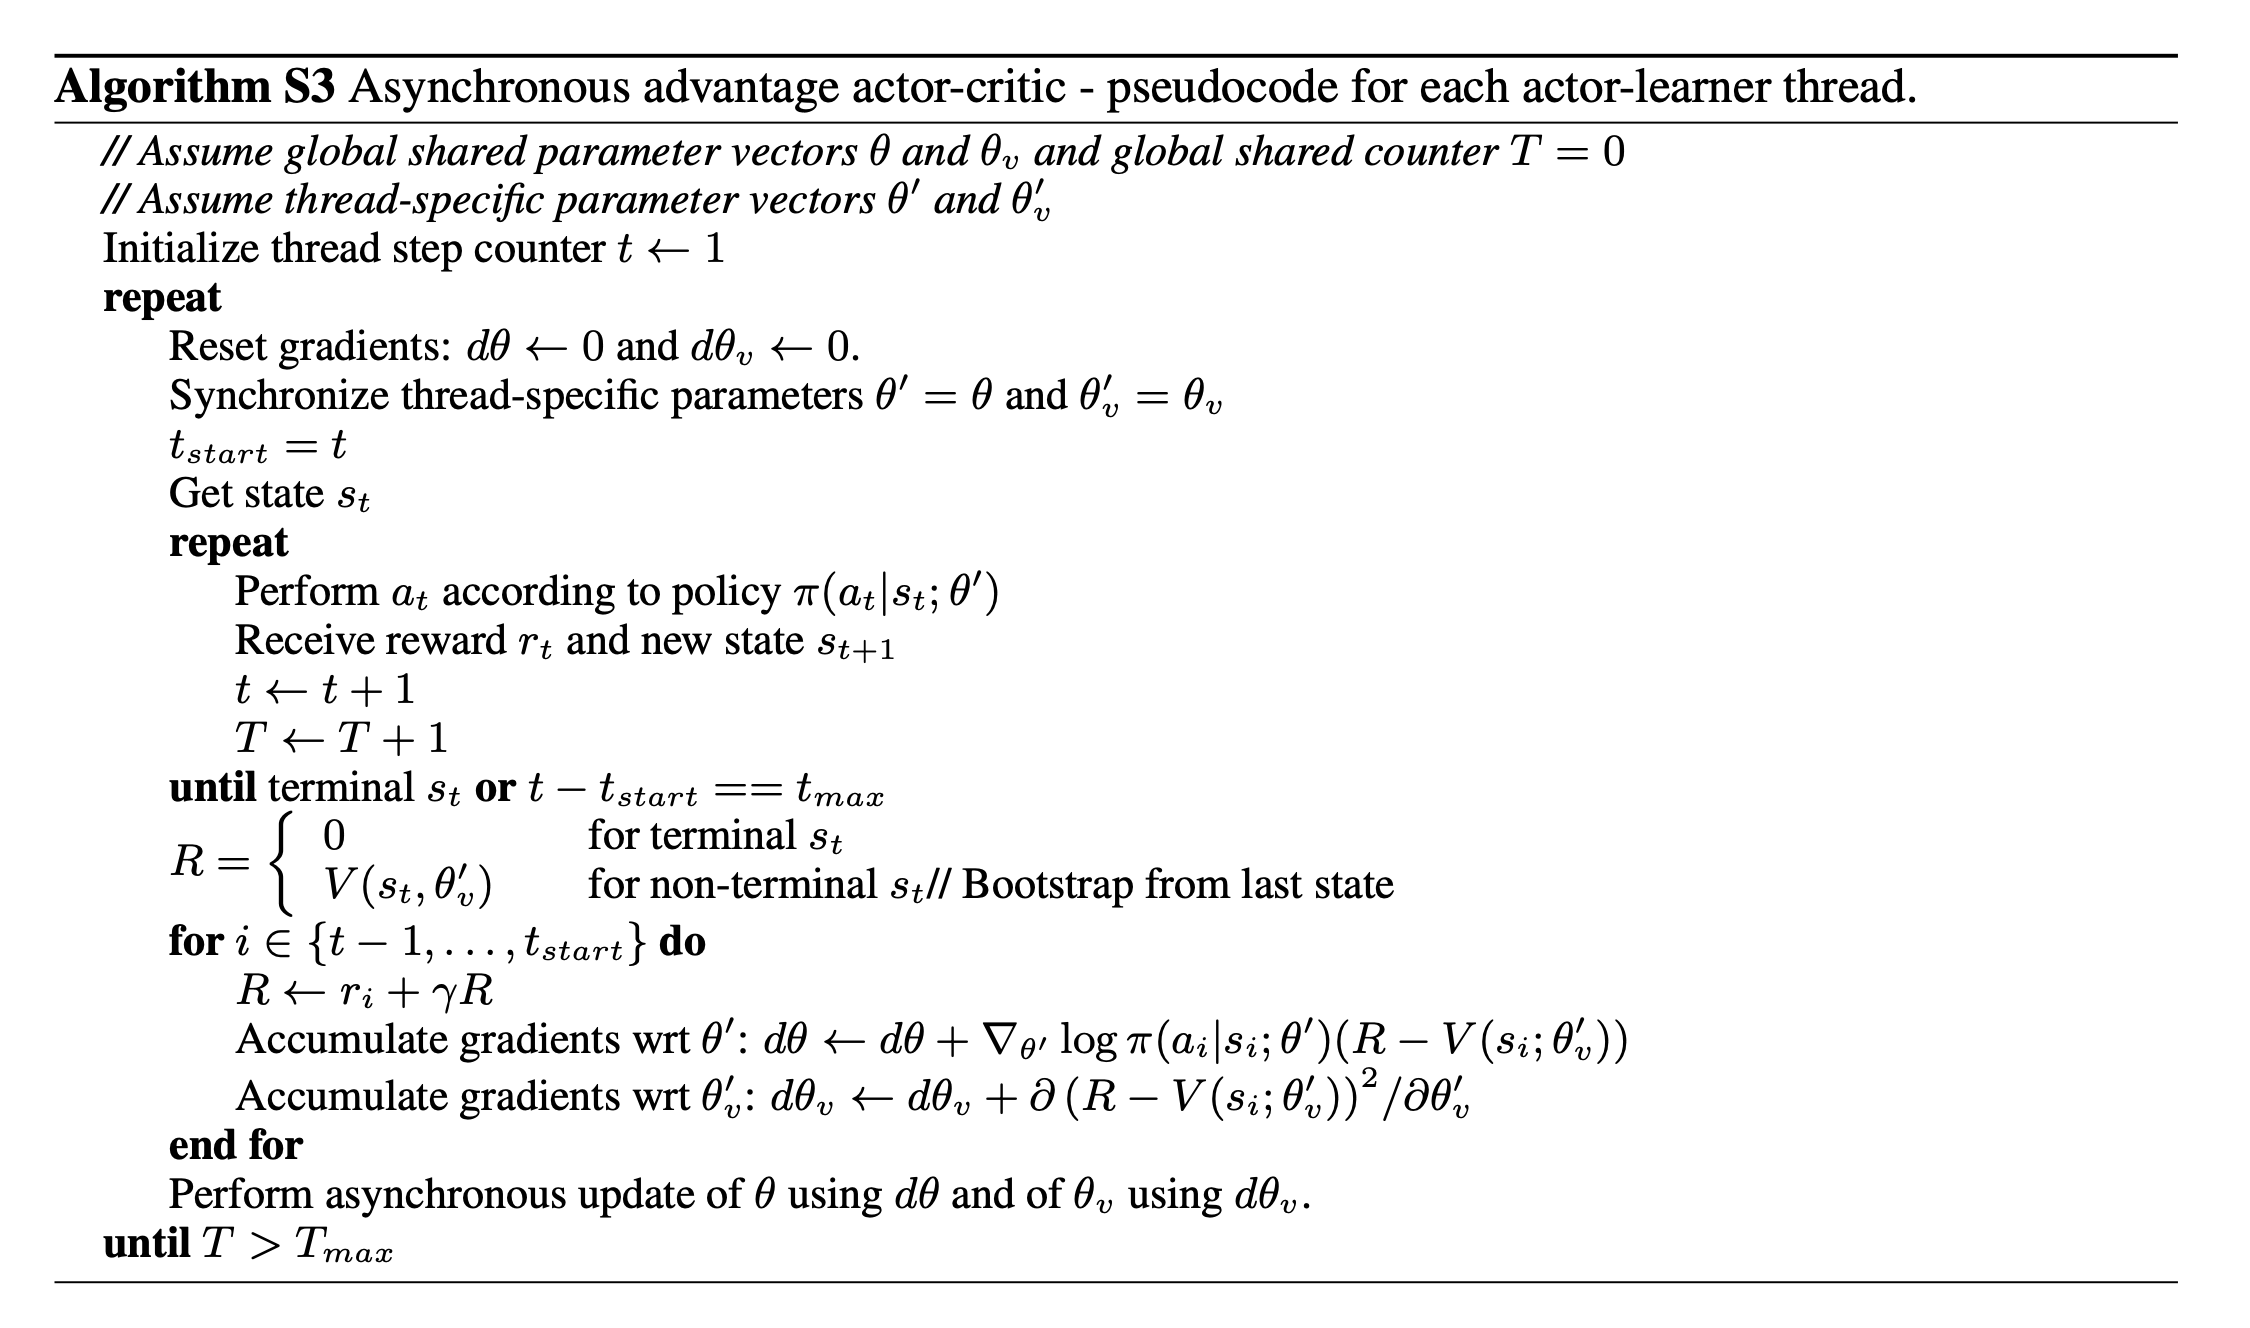

A brief outline for what you'll do below:
1. Run the following cell and the one after it, thus creating your actor and critic networks
2. Write a function `run_episode` which generates actions, rewards, and general information about an episode (which is just a run of the network that either hits a terminal state, or exceeds the set max number of iterations per episode)
3. Write a function `process_episode` which will actually implement the A2C learning step.

Referring to the pseudocode above for the A2C algorithm will be crucial for steps 2 and 3. The paper will also serve as a particularly useful resource.

In [ ]:
class ActorCritic(nn.Module):
  def __init__(self, input_dim, output_dim, num_layers=3, layer_type=nn.Linear, nonlinearity=nn.Tanh):
    super().__init__()
    layers = OrderedDict()
    num_neurons = output_dim * np.power(4, num_layers) 

    layers['input_layer'] = layer_type(input_dim, num_neurons)
    layers['input_nl'] = nonlinearity()

    for i in range(num_layers):
      num_neurons_out = int(num_neurons / 4)
      layers['layer{}'.format(i)] = layer_type(num_neurons, num_neurons_out)
      layers['{}_nl'.format(i)] = nonlinearity()
      num_neurons = num_neurons_out

    self.function_approximator = nn.Sequential(layers)

    self.critic = nn.Linear(num_neurons_out, 1)
    self.actor = nn.Linear(num_neurons_out, num_neurons_out - 1)
    self.log_std = nn.Parameter(torch.ones(num_neurons_out - 1) * 0, requires_grad=True)
  
  def forward(self, X):
    X_transform = X
    if isinstance(X_transform, np.ndarray):
      X_transform = torch.from_numpy(X_transform).float()
    else:
      raise TypeError('must call forward() with a torch or numpy array')

    features = self.function_approximator(X_transform)
    return {'mean' : self.actor(features), 'std' : self.log_std}, self.critic(features)

In [ ]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
actor_critic = ActorCritic(state_size, action_size + 1)

# get optimizers set up since we will definitely not be doing that from scratch
ac_optim = torch.optim.Adam(actor_critic.parameters(), lr=1e-2)

# a few paramters - feel free to toggle these and see what happens
discount_factor = 0.99  # usually called gamma
epochs = 1000
max_steps_per_epoch = 200

print(env.observation_space)
print(env.action_space)

The output of the cell above shows you that the Lunar Lander observation space is eight dimensional (as John told you on Monday), and the action space is 2 dimensional. From the code comments for the LunarLander-v2 continuous source:

```
# Action is two floats [main engine, left-right engines].
# Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. 
# Engine can't work with less than 50% power.
# Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
```
(source: https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)

The fact that the action space is a `Box` type (this comes from `gym`) indicates that this is a continuous control problem. For this reason, it makes sense to use an actor-critic architecture.

### Let's see what an untrained agent of our own making does...


In [ ]:
visualize_policy(actor_critic, log_dir, use_sb_api=False)

pretty bad... So, let's train it!

### First, let's get a helper function going for running episodes

This will make our code much easier to parse when it gets to training. The following pseudo code should be what your `run_episode` function attempts to do:

```
in_terminal_state = False
while not in_terminal_state:
  1. actor maps environment state to action probability distribution 
    (we'll just use an isotropic normal distribution here - look into `torch.distributions.Normal`)
  2. actor samples distribution to choose action on this trial
  3. environment state is progressed by action, the next state and reward are returned
  4. record the negative log probability of having taken that action given the distribution 
  parameterized by the actor network (NB: If you use an isotropic Gaussian, then each action is 
  independent, and so their log probabilities add to get the total log probability of taking the 
  multidimensional action)
  5. if we've exceeded the max number of steps per episode, break out of the loop

return rewards, negative log probs, values of states, and whether we ended in a terminal state
```

To get you going, and to constrain the solution set a bit, note the `namedtuple`, `Episode`, defined below. Your `run_episode` should return an `Episode`, which has the fields `rew` (rewards), `action_nlps` (action negative log probabilities), `values` (state values) and `terminated` (whether we ended in a terminal state)

Hint: Note that the `forward()` method on our network returns a dict. Look at the fields. How can you use this to sample actions?
  

In [ ]:
Episode = namedtuple('Episode', 'rew action_nlps values terminated')

def run_episode(max_steps, actor_critic, env):
  pass

### Now that we have an episode runner, we can do the hard part. 

This is where we'll calculate the return, the advantage, and the losses for the actor and critic. Because the actor and critic share many parameters, and also a single optimizer, you should try and come up with a loss variable that captures both losses.

Hint: if you get exploding gradients, look into `torch.nn.utils.clip_grad_norm_`

In [ ]:
def process_episode(episode, actor_critic, ac_optim):
  pass


### If you wrote your `run_episode` and `process_episode` functions correctly...
You should be able to run the following three cells and see how your network trained / performed on the task! In other words, if you've made it this far (and your output looks reasonable...), you have successfully implemented A2C! If your solution looks suboptimal, try tinkering with some parameters. It's also possible that there's some off-by-one error in your code.

In [ ]:
log_dir = "/tmp/gym/your_impl/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make('LunarLanderContinuous-v2')
env = Monitor(env, log_dir)

epochs = 3000
for _ in range(epochs):
  ep = run_episode(max_steps_per_epoch, actor_critic, env)

  assert isinstance(ep, Episode), \
    "remember to return an Episode instance from run_episode"
  
  process_episode(ep, actor_critic, ac_optim)

In [ ]:
plot_results(log_dir)

In [ ]:
visualize_policy(actor_critic, log_dir, use_sb_api=False)

## Part 2C: Bonus exercise: Explore a little more

The original A3C paper mentions using entropy regularization to encourage exploration at the beginning of training. Modify your `run_episode` and `process_episode` functions to include an entropy regularization term in your loss. You'll probably need to modify the `Episode` namedtuple to keep track of the distribution entropy. Use the cells below to redefine your `run_episode` and `process_episode` in `run_episode_entropy` and `process_episode_entropy` below.

In [ ]:
Episode = namedtuple('Episode', 'rew action_nlps values entropies terminated')

def run_episode_entropy(max_steps, actor_critic, env):
  pass

In [ ]:
def process_episode_entropy(episode, actor_critic, ac_optim):
  pass

In [ ]:
actor_critic = ActorCritic(state_size, action_size + 1)

# get optimizers set up since we will definitely not be doing that from scratch
ac_optim = torch.optim.Adam(actor_critic.parameters(), lr=1e-2)

log_dir = "/tmp/gym/your_impl_entropy/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make('LunarLanderContinuous-v2')
env = Monitor(env, log_dir)

epochs = 3000
for _ in range(epochs):
  ep = run_episode_entropy(max_steps_per_epoch, actor_critic, env)

  assert isinstance(ep, Episode), \
    "remember to return an Episode instance from run_episode"
  
  process_episode_entropy(ep, actor_critic, ac_optim)

In [ ]:
plot_results(log_dir)

In [ ]:
visualize_policy(actor_critic, log_dir, use_sb_api=False)